# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [2]:
pip install --upgrade scikit-learn


     |████████████████████████████████| 12.2 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 89.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


## Подготовка данных

In [3]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import time

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Переведем все названия столбцов в нижный регист, а затем в змеиный регистр**

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data = data.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

In [8]:
data.number_of_pictures

0         0
1         0
2         0
3         0
4         0
         ..
354364    0
354365    0
354366    0
354367    0
354368    0
Name: number_of_pictures, Length: 354369, dtype: int64

In [9]:
#удалим столбцы, которые не влияют на цену
data = data.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [10]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [11]:
# найдем количество пропусков
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [12]:
for column in data:
    if data[column].isna().mean() != 0:
        print('Доля пропусков в',column,': {:.2%}'.format(data[column].isna().mean()))

Доля пропусков в vehicle_type : 10.58%
Доля пропусков в gearbox : 5.60%
Доля пропусков в model : 5.56%
Доля пропусков в fuel_type : 9.28%
Доля пропусков в repaired : 20.08%


In [13]:
#Посмотрим на значение в столбце repaired
data.repaired.value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [14]:
# выведем столбцы с пропусками
data[data['vehicle_type'].isna() & data['fuel_type'].isna() & data['model'].isna()&data['repaired'].isna()&data['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


In [15]:
# удалими строки так, чтобы из 5 столбцов c пропусками, удалились 3 с пропусками из этого списка
data = data.dropna(subset=['vehicle_type', 'fuel_type', 'model', 'repaired','gearbox'], thresh = 3)

In [16]:
data.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [17]:
# найдем уникальные значения столбца "тип топлива"
data.fuel_type.value_counts()

petrol      213687
gasoline     97814
lpg           5254
cng            561
hybrid         230
other          169
electric        86
Name: fuel_type, dtype: int64

**Насколько я помню petrol и gasoline - слова обозначабщие бензин в UK и в USA, поэтому заменим gasoline**


In [18]:
# переименуем gasoline в petrol, поскольку оба означают "бензин"
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')

In [19]:
data.fuel_type.value_counts()

petrol      311501
lpg           5254
cng            561
hybrid         230
other          169
electric        86
Name: fuel_type, dtype: int64

In [20]:
# заполним пропуски значением other.
data.fuel_type.fillna('other', inplace=True)

In [21]:
# найдем уникальные значения в столбце "тип кузова"
data.vehicle_type.value_counts()

sedan          90870
small          79059
wagon          64683
bus            28570
convertible    20010
coupe          15995
suv            11896
other           3136
Name: vehicle_type, dtype: int64

In [22]:
# поскольку нет возможности узнать тип кузова, заменим пропуски в этом столбце на other
data.vehicle_type.fillna('other', inplace=True)

In [23]:
# найдем уникальные значения стобца "коробка передач"
data.gearbox.value_counts()

manual    262289
auto       65098
Name: gearbox, dtype: int64

In [24]:
# заполним пропуски значением "unknown"
data.gearbox.fillna('unknown', inplace=True)

In [25]:
# в столбце "модель" и "был в ремонте" тоже заполним пропуски на unknown
data.model.fillna('unknown', inplace=True)

In [26]:
data.repaired.fillna('unknown', inplace=True)

In [27]:
#проверим пропуски
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [28]:
# найдем уникальные значения в столбце "год регистрации"
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989,
       2015, 1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941,
       1962, 1929, 1957, 1940, 1949, 1937, 1951, 1953, 2019, 2900, 6000,
       1400, 1950, 4000, 1948, 1952, 1200, 1932, 3700, 5000, 1942, 1935,
       1933, 1936, 6500, 1923, 1930, 1943, 1934, 1938, 9000, 1000, 1919,
       1928, 1931, 1602, 1927, 1947, 1946, 7500, 1944, 1600])

Удалим все строки с годом после 2024, и, поскольку автомобили до 1900 года это скорее всего аномалии, удалим их тоже

In [29]:
df = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1900)]

<AxesSubplot:>

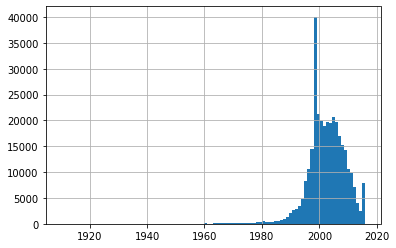

In [30]:
df['registration_year'].hist(bins = 100)

In [31]:
# найдем уникальные значения в столбце "мощность"
df['power'].value_counts()

0        27732
75       22234
60       14739
150      13922
101      12496
         ...  
584          1
15001        1
8011         1
1436         1
2172         1
Name: power, Length: 691, dtype: int64

<AxesSubplot:>

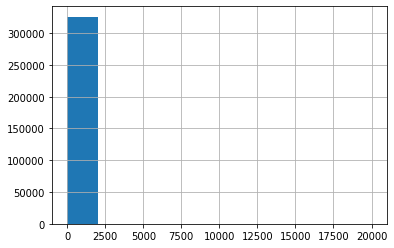

In [32]:
df['power'].hist()

In [33]:
# удалим аномалии - скорость больше 700 лошадиных сил
df = df.loc[df['power'] <= 800]

<AxesSubplot:>

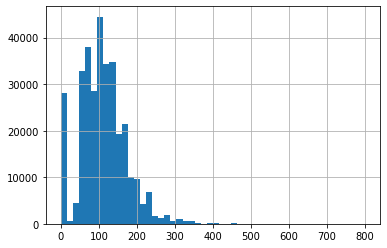

In [34]:
df['power'].hist(bins = 50)

In [35]:
# заменим нули медианой 
power_med = df['power'].median()

In [36]:
df['power'] = df['power'].replace(0, power_med)

<AxesSubplot:>

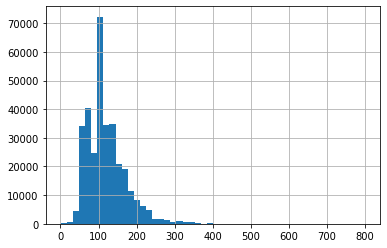

In [37]:
df['power'].hist(bins = 50)

In [38]:
# проверим на аномалии значения столбца "цена"
df['price'].value_counts()

0        7566
500      5061
1500     4863
1200     4127
2500     4085
         ... 
1035        1
5385        1
15232       1
6788        1
8188        1
Name: price, Length: 3651, dtype: int64

<AxesSubplot:>

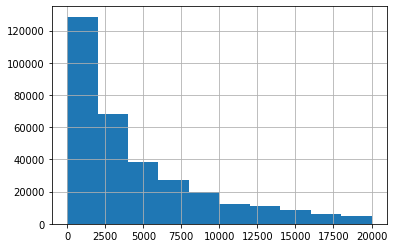

In [39]:
df['price'].hist()

In [40]:
# нулевых значений не так много. удалим их 
df = df.loc[df['price'] > 0]

In [41]:
df['price'].value_counts()

500      5061
1500     4863
1200     4127
2500     4085
1000     4050
         ... 
16430       1
3003        1
10375       1
6785        1
8188        1
Name: price, Length: 3650, dtype: int64

In [42]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,105.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


In [43]:
# проверим данные на дубликаты
df.duplicated().sum()

42531

In [44]:
#удалим дубликаты(с удалением старых индексов и формированием новых)
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()#проверим

0

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275505 entries, 0 to 275504
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              275505 non-null  int64  
 1   vehicle_type       275505 non-null  object 
 2   registration_year  275505 non-null  int64  
 3   gearbox            275505 non-null  object 
 4   power              275505 non-null  float64
 5   model              275505 non-null  object 
 6   kilometer          275505 non-null  int64  
 7   fuel_type          275505 non-null  object 
 8   brand              275505 non-null  object 
 9   repaired           275505 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.0+ MB


**Вывод**  
В этом разделе мы произвели предобработку данных. На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий. Удалили дубликаты и перевели категориальные значения столбцов в количественные. В итоге у нас образовалась таблица в 284 тыс. строк и 10 столбцов.

<AxesSubplot:>

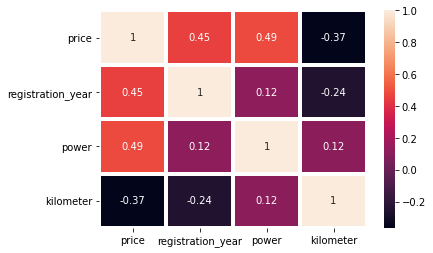

In [46]:
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

По таблиице видно, что наблюадется средняя корреляция между мощностью от цены и датой регистрации авто от цены. Также наблюдается обратная корреляция цены от пробега автомобился.

Что в целом логично, чем больше мощность авто - тем больше цена. И также с пробегом: чем больше пробег - тем цена должна уменьшаться

## Обучение моделей

Проверим модели на 2 разных датасетов с различными способами кодировки:

1. Ordinal Encoding
2. One-Hot Enconding

In [47]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,105.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


In [48]:
oh_encoder = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output=False)
standard_scaler = StandardScaler()
ord_encoder = OrdinalEncoder( dtype=int)

In [49]:
ohe_column = ['vehicle_type', 'gearbox',  'fuel_type',  'repaired','brand','model']
standart_column = ['registration_year', 'power', 'kilometer']

In [50]:
X = df.drop('price', axis=1)
y = df['price']
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y,
  test_size=0.2,
  random_state=RANDOM_STATE)

In [51]:
# Преобразование категориальных признаков
X_train_encoded_class = oh_encoder.fit_transform(X_train[ohe_column])
X_test_encoded_class = oh_encoder.transform(X_test[ohe_column])


# Масштабирование количественных признаков
X_train_scaled_class = standard_scaler.fit_transform(X_train[standart_column])
X_test_scaled_class = standard_scaler.transform(X_test[standart_column])


X_train_full_lin = np.hstack((X_train_encoded_class, X_train_scaled_class))
X_test_full_lin = np.hstack((X_test_encoded_class, X_test_scaled_class))

In [52]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

**LinearRegression**

In [53]:
%%time
model_lr = LinearRegression()

parameters = {'fit_intercept': [True, False],
              'copy_X': [True, False]}



rs_lr = RandomizedSearchCV(
    model_lr,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring = scorer,
    random_state=RANDOM_STATE)


start = time.time()

rs_lr.fit(X_train_full_lin, y_train)

end = time.time()


best_params_lr = rs_lr.best_params_
best_score_lr = round((-1 * rs_lr.best_score_)**0.5)
time_fit_lr = start-end

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 4min 35s, sys: 2min 12s, total: 6min 47s
Wall time: 6min 50s


In [54]:
print(f"Лучшие параметры модели:{best_params_lr}\n\n Лучшая метрика модели: {best_score_lr}\n\n Время обучения модели {time_fit_lr}")

Лучшие параметры модели:{'fit_intercept': True, 'copy_X': True}

 Лучшая метрика модели: 2724

 Время обучения модели -410.0269069671631


In [55]:
best_model_lr = LinearRegression(fit_intercept = True, copy_X = True)

In [56]:
start = time.time()

best_model_lr.fit(X_train_full_lin, y_train)

end = time.time()

time_fit_lr = end-start

In [57]:
best_model_lr_pred = best_model_lr.predict(X_train_full_lin)
start = time.time()

best_model_lr.predict(X_train_full_lin)

end = time.time()

time_pred_lr = end-start

In [58]:
models_compares = {
    'LinearRegression': {
        'fit_time': time_fit_lr,
        'pred_time': time_pred_lr,
        'rmse': best_score_lr,
    },
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,pred_time,rmse
LinearRegression,18.847027,0.299473,2724.0


**Модель CatBoostRegressor()**

In [59]:
standart_column = ['registration_year', 'power', 'kilometer']
ord_column = ['brand','model','vehicle_type', 'gearbox',  'fuel_type',  'repaired']

In [60]:
# Масштабирование количественных признаков
X_train_scaled_class = standard_scaler.fit_transform(X_train[standart_column])
X_test_scaled_class = standard_scaler.transform(X_test[standart_column])

# Преобразование категориальных признаков
X_train_ord_class = ord_encoder.fit_transform(X_train[ord_column])
X_test_ord_class = ord_encoder.transform(X_test[ord_column])


X_train_full_ord = np.hstack((X_train_scaled_class, X_train_ord_class))
X_test_full_ord = np.hstack((X_test_scaled_class, X_test_ord_class))


In [61]:
%%time
model_CBR = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

param_CBR = {'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300]
}

rs_CBR = RandomizedSearchCV(
    model_CBR ,
    param_CBR,
    n_jobs=-1,
    cv=3,
    scoring = scorer,
    random_state=RANDOM_STATE)


start = time.time()

rs_CBR.fit(X_train_full_ord, y_train)

end = time.time()


best_params_CBR = rs_CBR.best_params_
best_score_CBR = round((-1 * rs_CBR.best_score_)**0.5)
time_CBR = start-end

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 2min 11s


In [62]:
print(f"Лучшие параметры модели:{best_params_CBR}\n\n Лучшая метрика модели: {best_score_CBR}\n\n Время обучения модели {time_CBR}")

Лучшие параметры модели:{'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}

 Лучшая метрика модели: 1800

 Время обучения модели -131.71662545204163


In [63]:
best_model_CBR = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, learning_rate = 0.1, l2_leaf_reg = 5, iterations = 300, depth = 8)

In [64]:
%%time

start = time.time()

best_model_CBR.fit(X_train_full_ord, y_train)

end = time.time()

time_fit_CBR = end-start

CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 11.4 s


In [65]:
%%time
best_model_CBR_pred = best_model_CBR.predict(X_train_full_ord)

start = time.time()

best_model_CBR.predict(X_train_full_ord)

end = time.time()

time_pred_CBR = end=start

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


In [66]:
models_compares['CatBoostRegressor'] = {
        'fit_time': time_fit_CBR,
        'pred_time' : time_pred_CBR,
        'rmse': best_score_CBR
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,pred_time,rmse
LinearRegression,18.847027,2.994730e-01,2724.0
CatBoostRegressor,11.350240,1.716240e+09,1800.0


**LightGBM**

In [1]:
%%time
model_LGBMR = LGBMRegressor(random_state=RANDOM_STATE)

param_LGBMR = {
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.2],
    'max_depth': [5, 7]
}

rs_LGBMR = RandomizedSearchCV(
    model_LGBMR ,
    param_LGBMR,
    n_jobs=-1,
    cv=3,
    scoring = scorer,
    random_state=RANDOM_STATE)


start = time.time()

rs_LGBMR.fit(X_train_full_ord, y_train)

end = time.time()


best_params_LGBMR = rs_LGBMR.best_params_
best_score_LGBMR = round((-1 * rs_LGBMR.best_score_)**0.5)
time_LGBMR = end-start

print(f"Лучшие параметры модели:{best_params_LGBMR}\n\n Лучшая метрика модели: {best_score_LGBMR}\n\n Время обучения модели {time_LGBMR}")

NameError: name 'LGBMRegressor' is not defined

In [68]:
best_model_LGBMR = LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 300, max_depth = 7, learning_rate = 0.2)

In [69]:
%%time
start = time.time()

best_model_LGBMR.fit(X_train_full_ord, y_train)

end = time.time()

time_fit_LGBMR = end-start

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.4 s


In [70]:
%%time
best_model_LGBMR_pred = best_model_LGBMR.predict(X_train_full_ord)

start = time.time()

best_model_LGBMR.predict(X_train_full_ord)

end = time.time()

time_pred_LGBMR =end-start

CPU times: user 7.18 s, sys: 0 ns, total: 7.18 s
Wall time: 7.21 s


In [71]:
models_compares['LGBMRegressor'] = {
        'fit_time': time_fit_LGBMR,
        'pred_time' : time_pred_LGBMR,
        'rmse': best_score_LGBMR
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,pred_time,rmse
LinearRegression,18.847027,2.994730e-01,2724.0
CatBoostRegressor,11.350240,1.716240e+09,1800.0
LGBMRegressor,14.408500,3.514341e+00,1664.0


**RandomForestRegressor**

In [72]:
%%time

model_RFR = RandomForestRegressor(random_state = RANDOM_STATE)

param_RFR = {
        'max_depth': range(4,10),
        'min_samples_split': range(2, 5)
    }
rs_RFR = RandomizedSearchCV(
    model_RFR,
    param_RFR,
    n_jobs=-1,
    cv=3,
    scoring = scorer,
    random_state=RANDOM_STATE)


start = time.time()

rs_RFR.fit(X_train_full_ord, y_train)

end = time.time()


best_params_RFR = rs_RFR.best_params_
best_score_RFR = round((-1 * rs_RFR.best_score_)**0.5)
time_RFR = end-start

print(f"Лучшие параметры модели:{best_params_RFR}\n\n Лучшая метрика модели: {best_score_RFR}\n\n Время обучения модели {time_RFR}")

Лучшие параметры модели:{'min_samples_split': 2, 'max_depth': 9}

 Лучшая метрика модели: 2009

 Время обучения модели 371.7751145362854
CPU times: user 6min 11s, sys: 0 ns, total: 6min 11s
Wall time: 6min 11s


In [73]:
best_model_RFR = RandomForestRegressor(random_state = RANDOM_STATE, min_samples_split = 3, max_depth = 9)

In [74]:
%%time
start = time.time()

best_model_RFR.fit(X_train_full_ord, y_train)

end = time.time()

time_fit_RFR = end-start

CPU times: user 23.1 s, sys: 0 ns, total: 23.1 s
Wall time: 23.1 s


In [75]:
%%time
best_model_RFR_pred = best_model_RFR.predict(X_train_full_ord)

start = time.time()

best_model_RFR.predict(X_train_full_ord)

end = time.time()

time_pred_RFR = end-start

CPU times: user 2.97 s, sys: 0 ns, total: 2.97 s
Wall time: 2.97 s


In [76]:
models_compares['RFRegressor'] = {
        'fit_time': time_fit_RFR,
        'pred_time' :time_pred_RFR,
        'rmse':best_score_RFR
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,pred_time,rmse
LinearRegression,18.847027,2.994730e-01,2724.0
CatBoostRegressor,11.350240,1.716240e+09,1800.0
LGBMRegressor,14.408500,3.514341e+00,1664.0
RFRegressor,23.115695,1.490621e+00,2009.0


**DummyRegressor**

In [77]:
%%time
# создание и обучение модели DummyRegressor
model_dummy = DummyRegressor()

param_dummy = {'strategy' : ["mean"]}

rs_dummy = RandomizedSearchCV(
    model_dummy,
    param_dummy,
    n_jobs=-1,
    cv=3,
    scoring = scorer,
    random_state=RANDOM_STATE)


start = time.time()

rs_dummy.fit(X_train_full_ord, y_train)

end = time.time()


best_params_dummy = rs_dummy.best_params_
best_score_dummy = round((-1 * rs_dummy.best_score_)**0.5)
time_dummy = end-start

print(f"Лучшие параметры модели:{best_params_dummy}\n\n Лучшая метрика модели: {best_score_dummy}\n\n Время обучения модели {time_dummy}")

Лучшие параметры модели:{'strategy': 'mean'}

 Лучшая метрика модели: 4627

 Время обучения модели 0.027364253997802734
CPU times: user 29.2 ms, sys: 0 ns, total: 29.2 ms
Wall time: 27.9 ms


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [78]:
best_model_dummy = DummyRegressor(strategy = 'mean')

In [79]:
%%time

start = time.time()

best_model_dummy.fit(X_train_full_ord, y_train)

end = time.time()

time_fit_dummy = end-start

CPU times: user 982 µs, sys: 0 ns, total: 982 µs
Wall time: 793 µs


In [80]:
%%time

best_model_dummy_pred = best_model_dummy.predict(X_train_full_ord)

start = time.time()

best_model_dummy.predict(X_train_full_ord)

end = time.time()

time_pred_dummy = end-start

CPU times: user 1.32 ms, sys: 0 ns, total: 1.32 ms
Wall time: 1.05 ms


In [81]:
models_compares['DummyRegressor'] = {
        'fit_time': time_fit_dummy,
        'pred_time' : time_pred_dummy,
        'rmse':best_score_dummy
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,pred_time,rmse
LinearRegression,18.847027,2.994730e-01,2724.0
CatBoostRegressor,11.350240,1.716240e+09,1800.0
LGBMRegressor,14.408500,3.514341e+00,1664.0
RFRegressor,23.115695,1.490621e+00,2009.0
DummyRegressor,0.000772,4.651546e-04,4627.0


## Анализ моделей

In [82]:
models_statistics.sort_values(by ='rmse')

,fit_time,pred_time,rmse
LGBMRegressor,14.408500,3.514341e+00,1664.0
CatBoostRegressor,11.350240,1.716240e+09,1800.0
RFRegressor,23.115695,1.490621e+00,2009.0
LinearRegression,18.847027,2.994730e-01,2724.0
DummyRegressor,0.000772,4.651546e-04,4627.0


Лучшей моделью оказалась **LGBMRegressor (n_estimators = 300, max_depth = 7, learning_rate = 0.2)** с метрикой RSME **1660**. Проверим ее на тестовой выборке.


In [83]:
%%time
best_model = LGBMRegressor (random_state=RANDOM_STATE, n_estimators = 300, max_depth = 7, learning_rate = 0.2)

start = time.time()

best_model.fit(X_train_full_ord, y_train)

end = time.time()

time_best_model_fit = end-start

CPU times: user 11.9 s, sys: 0 ns, total: 11.9 s
Wall time: 12.1 s


In [84]:
%%time
start = time.time()

predict = best_model.predict(X_test_full_ord)

end = time.time()

time_best_model_pred = end-start

CPU times: user 958 ms, sys: 0 ns, total: 958 ms
Wall time: 907 ms


In [85]:
best_model_rmse = round(mean_squared_error(predict, y_test) ** 0.5)
print(f'RMSE тестовой выборки: {best_model_rmse}')

RMSE тестовой выборки: 1646


In [86]:
models_compares_1 = {
        'model':'LGBMRegressor',
        'fit_time': time_best_model_fit,
        'test_time': time_best_model_pred,
        'test_rmse': best_model_rmse}
models_statistics_1_3 = pd.DataFrame(models_compares_1, index = [0])
models_statistics_1_3

,model,fit_time,test_time,test_rmse
0,LGBMRegressor,12.065123,0.906672,1646


## Вывод

1. Были загружены данные и проанализированы. В результате были выявлены пропуски в vehicle_type, gearbox , model , fuel_type , repaired и обнаружены аномалии;  

2. В ходе обработки данных были заполены пропуски, обработаны аномалии и удалены признаки, не несущие важности при обучении моделей.  

3. Данные были подготовлены для обучения. Разделены на обучающую, валидационную и тестовую выборку. Закодированы двумя методами: Ordinal Encoding и One-Hot Encoding;  

4. В качестве моделей были выбраны: LinearRegression, CatBoost, LightGBM.
Наилучший результат показала LightGBM с кодировкой данных - (n_estimators = 300, max_depth = 7, learning_rate = 0.2)** с метрикой RSME **1660** при корсвалидации и **1647** на тестовой выборке, при времени 